In [15]:
import time

! pip  install lmfit

import numpy as np
import pandas as pd
from math import sqrt
import matplotlib.pyplot as plt

import statsmodels.api as sm
import statsmodels.stats as stats
from scipy.stats import pearsonr
from lmfit import Parameters, minimize # package to apply NLS
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error

     |████████████████████████████████| 266kB 4.9MB/s 
     |████████████████████████████████| 61kB 8.2MB/s 
     |████████████████████████████████| 235kB 15.2MB/s 
  Created wheel for lmfit: filename=lmfit-1.0.0-cp36-none-any.whl size=87917 sha256=b37addf671f10345362917dbc24b85b48ce0281d702524cd32c3ef0eeaec504f
  Stored in directory: /root/.cache/pip/wheels/1f/93/e9/8d3f759e466f5bbfed3ba1d7dc5b3d4389c469a1ec9a2acaee
  Created wheel for asteval: filename=asteval-0.9.18-cp36-none-any.whl size=17381 sha256=54641a88b4a55073c9e40dd04389f00443a19cb96de251bb5b4cdd0fad61b540
  Stored in directory: /root/.cache/pip/wheels/1c/53/1b/28d929700c9633b1786a4982e6db564ec8326a8930234dcc19
  Created wheel for uncertainties: filename=uncertainties-3.1.2-cp36-none-any.whl size=96456 sha256=c5271c877593d9856a877a96e58f040e20683c47bc8cb39df76d6159f50df327
  Stored in directory: /root/.cache/pip/wheels/d9/d3/0e/5b0b743a8abd50373705427438456da5dc2621891138d7a618
Successfully built lmfit asteval uncertainties

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
# set seed for reproducibility
np.random.seed(1)

def growth_rate(x, steps=1):
  return x[steps:]-x[:-steps]
  
def create_DGP(N, T, alpha, var_eps):
  # Function that takes all necessary parameters and returns a simulated dataset [NxT]
  Y=np.random.rand(N, T)
  for i in range(N):
    Y[i, 0]=0
    theta = np.random.uniform(1, alpha, 1)
    for t in range(1, T):
      epsilon = np.random.normal(0, sqrt(var_eps), 1)
      Y[i, t]=theta+Y[i, t-1]+epsilon

  # unit tests for simulating DGP
  assert np.mean(Y, axis = 0)[0] == 0 # start time series 0 at t=0
  return Y

In [0]:
assert type(create_DGP(2, 5, 1,1)) == np.ndarray
Y = create_DGP(10, 50, 1,1)

In [0]:
def CRDW(Y, i, tao=0.4):
  """This function tests for cointegration
      Args:
        i (int): index of the country we are modeling
        tao (float): critical value (default = 0.4)

      Returns:
        JH (array): An array with the regressors (incl. self)

  """
  N, T = Y.shape
  JH=Y[i][1:]
  for j in range(N):
      if j!=i:
        y = Y[i]
        x = Y[j]
        x = sm.add_constant(x)

        model = sm.OLS(y, x)
        results = model.fit()
        CRDW_j = stats.stattools.durbin_watson(results.resid)
        if CRDW_j > tao:
          JH = np.vstack((JH, Y[j][1:]))
  assert JH.shape[0]>0 # test if JH contains atleast self
  
  return JH

In [0]:
def max_min_correlations(Y, i, kn=4, kp=4):
    """Feature selection based on pairwise correlation
    Args:
        Y_growth (array): matrix of levels (Y_growth)
        i (int): index of the country we are modeling
        tao (float): critical value (default = 0.4)

    Returns:
        JH (array): An array with the regressors (incl. self)

    """
    N, T = Y.shape
    Y_growth = np.vstack([growth_rate(row) for row in Y])
    

    corr_i = np.zeros(N)
    for j in range(N):
      corr_i[j] = pearsonr(Y_growth[i], Y_growth[j])[0]
    
    pos = Y_growth[np.argpartition(corr_i, -(kp+1))[-(kp+1):-1]]
    #pos = Y_growth[corr_i.argsort()[(kp+1):-1]]
    assert pos.shape == (kp, T-1)
    neg = Y_growth[corr_i.argsort()[:kn]]
    assert neg.shape == (kn, T-1)
    #neg = Y_growth[np.argpartition(correlation(7), -5)[-5:-1]]
    self_gr = Y_growth[i]
    return pos, neg, self_gr

In [0]:
def rolling_training(T1_size, t, rank, JH, pos, neg, self_gr):
  if rank > 1:
    JH_T1 = JH[:, t:t+T1_size]
  else:
    JH_T1 = JH[t:T1_size+t]
  pos_T1 = pos[:, t:t+T1_size]
  neg_T1 = neg[:, t:t+T1_size]
  self_T1 = self_gr[t:T1_size+t]
  # TODO: add tests 
  # unit tests
  print(pos_T1.shape)
  assert pos_T1.shape[0] == 4
  assert pos_T1.shape[1] == T1_size
  return JH_T1, pos_T1, neg_T1, self_T1

def rolling_test(T1_size, t, rank, JH, pos, neg, self_gr):
  if rank > 1:
    JH_T2 = JH[:, t+T1_size]
  else:
    JH_T2 = JH[T1_size+t]
  pos_T2 = pos[:, t+T1_size]
  neg_T2 = neg[:, t+T1_size]
  self_T2 = self_gr[T1_size+t]
  # TODO: add tests 
  # unit tests
  assert pos_T2.size == 4
  return JH_T2, pos_T2, neg_T2, self_T2

In [54]:
JH.size == 3*49

True

In [0]:
def define_parameters(Y, i):
  JH = CRDW(Y, i)
  pos, neg, self_gr = max_min_correlations(Y, i)

  params = Parameters()
  rank = JH.shape[0]
  if rank == Y.shape[1]-1:
    rank = 1
  for r in range(1, rank):
    params.add('beta'+str(r), value = np.random.normal(-1, 1), max=0)

  assert rank < Y.shape[1]-1

  params.add('mu', value = np.random.normal(0, 1))
  params.add('alpha_self', value = np.random.normal(0, 1))
  params.add('alpha_pos', value = np.random.normal(0, 1))
  params.add('alpha_neg', value = np.random.normal(0, 1))
  params.add('theta_pos', value = np.random.normal(0, 1))
  params.add('theta_neg', value = np.random.normal(0, 1))
  params.add('gamma', value = np.random.normal(0, 1))

  #params.pretty_print()
  
  return JH, pos, neg, self_gr, params, rank

In [76]:
self_gr

array([ 1.64403111,  0.78384485,  1.83367881,  3.16045573,  2.99899201,
        1.76404142,  2.68725522, -0.30797134,  2.47239631,  1.0748761 ,
       -0.7869354 ,  1.16521059,  1.9762963 ,  0.30397233,  2.93713158,
        2.34922768, -0.27511386,  2.00909026,  1.11197269,  0.44831976,
        0.68336836,  0.555005  , -0.21627102,  0.55167689,  1.69268891,
        2.42594203,  2.45833834,  0.42663927,  0.88275232,  0.14062868,
        2.03000249, -0.64815292, -0.36327656,  0.3641533 ,  1.25147344,
        0.67885202,  1.03306391,  1.04753462,  1.23327973, -0.03446298,
        0.66064023,  1.57761234,  1.28022916,  2.09330663,  0.25377572,
        1.90626141,  2.46662474,  0.85740971,  1.26593014])

In [77]:
self_gr[T1_size:]

array([ 2.42594203,  2.45833834,  0.42663927,  0.88275232,  0.14062868,
        2.03000249, -0.64815292, -0.36327656,  0.3641533 ,  1.25147344,
        0.67885202,  1.03306391,  1.04753462,  1.23327973, -0.03446298,
        0.66064023,  1.57761234,  1.28022916,  2.09330663,  0.25377572,
        1.90626141,  2.46662474,  0.85740971,  1.26593014])

In [74]:
JH_T1, pos_T1, neg_T1, self_T1 = rolling_training(T1_size, 0, rank, JH, pos, neg, self_gr)
self_T1

array([ 1.64403111,  0.78384485,  1.83367881,  3.16045573,  2.99899201,
        1.76404142,  2.68725522, -0.30797134,  2.47239631,  1.0748761 ,
       -0.7869354 ,  1.16521059,  1.9762963 ,  0.30397233,  2.93713158,
        2.34922768, -0.27511386,  2.00909026,  1.11197269,  0.44831976,
        0.68336836,  0.555005  , -0.21627102,  0.55167689,  1.69268891])

In [69]:
growth_rate(Y[0])

array([-0.7452627 ,  0.43598636,  2.70806466,  0.74433918,  2.35236829,
        1.85356073,  1.09392315,  1.77104049, -0.58209685,  2.56084659,
       -0.45435071,  1.93390588,  0.67802845, -0.07543282,  1.40366308,
        3.15635192, -0.13571803,  0.44773088,  1.93846631,  2.30035718,
        2.72597708,  0.55671748,  1.43110608,  1.94232947, -0.25456436,
       -0.82198416,  1.74172503,  0.96959022,  0.93178409,  2.12351216,
        2.04012637,  1.15105366,  1.14638452,  1.47250404,  0.24197909,
        2.26964434,  2.0803012 ,  1.15297026,  1.34882228,  1.39571534,
        1.1059771 , -0.08709183,  1.20378972,  1.30157266,  1.35112149,
        0.94174421,  0.20543551, -0.19013806, -0.34153246])

In [70]:
growth_rate(Y[0])[(T-T1_size-1):] 

array([-0.25456436, -0.82198416,  1.74172503,  0.96959022,  0.93178409,
        2.12351216,  2.04012637,  1.15105366,  1.14638452,  1.47250404,
        0.24197909,  2.26964434,  2.0803012 ,  1.15297026,  1.34882228,
        1.39571534,  1.1059771 , -0.08709183,  1.20378972,  1.30157266,
        1.35112149,  0.94174421,  0.20543551, -0.19013806, -0.34153246])

In [0]:
# what should happen at every t in T2 range and what can happen at once? Rolling window so takes a while
# maybe can compare time with and without rolling window forecast

""" at every i
        JH, pos, neg, rank
        define parameters
            at every t in T2
                get train sample of length T1
                estimate parameters
                forecast 1-step ahead
            calculate RMPSE per i
    count #times we beat IMA over all countries per simulation run

repeat this 100 times for all different specifications
report average #times beaten / 100 for different specifications
"""

def run_simulation(Y,a):
  N = Y.shape[0]
  T = Y.shape[1]
  T1_size = int((T*a)/(1+a))

  RMSPE = np.zeros(N)
  RMSPE_IMA = np.zeros(N)
  beaten = 0

  for i in range(N):
    predictions = np.zeros(T-T1_size)
    predictions_IMA = np.zeros(T-T1_size)
    truth = growth_rate(Y[i])[T1_size:] # to check

    assert truth.size == T-T1_size
    assert predictions.size == T-T1_size
    assert predictions_IMA.size == T-T1_size

    JH, pos, neg, self_gr, params, rank = define_parameters(Y, i)

    for t in range(T-T1_size):
      JH_T1, pos_T1, neg_T1, self_T1 = rolling_training(T1_size, t, rank, JH, pos, neg, self_gr)
      out = minimize(residual, params, args=(pos, neg, self_gr, JH, rank), method='leastsq', maxfev=1000000)
      JH_T2, pos_T2, neg_T2, self_T2 = rolling_test(T1_size, t, rank, JH, pos, neg, self_gr)

      predictions[t] = step_forecast(pos_T2, neg_T2, JH_T2, self_T2, rank, params)
      # TODO: run IMA(1, 1)
      


    RMSPE_i = calculate_RMSPE(predictions, truth)
    #RMSPE_IMA_i = calculate_RMSPE(predictions_IMA, truth)
    if RMSPE_i<RMSPE_IMA_i:
      beaten += 1
  
  return beaten     


In [153]:
try: 
  run_simulation(Y, 1)
except: 
  print(i)

5


In [157]:
  a = 1
  N = Y.shape[0]
  T = Y.shape[1]
  T1_size = int((T*a)/(1+a))

  RMSPE = np.zeros(N)
  RMSPE_IMA = np.zeros(N)
  beaten = 0

  for i in range(5, 6):
    print(i)
    predictions = np.zeros(T-T1_size-1)
    predictions_IMA = np.zeros(T-T1_size-1)
    truth = growth_rate(Y[i])[T1_size:] # to check

    assert truth.size == T-T1_size-1
    assert predictions.size == T-T1_size-1
    assert predictions_IMA.size == T-T1_size-1

    JH, pos, neg, self_gr, params, rank = define_parameters(Y, i)

    for t in range(T-T1_size-1):
      try:
        JH_T1, pos_T1, neg_T1, self_T1 = rolling_training(T1_size, t, rank, JH, pos, neg, self_gr)
        out = minimize(residual, params, args=(pos, neg, self_gr, JH, rank), method='leastsq', maxfev=1000000)
        JH_T2, pos_T2, neg_T2, self_T2 = rolling_test(T1_size, t, rank, JH, pos, neg, self_gr)

        predictions[t] = step_forecast(pos_T2, neg_T2, JH_T2, self_T2, rank, params)
        # TODO: run IMA(1, 1)
      except:
        print(str(t) + 'oops')

    RMSPE_i = calculate_RMSPE(predictions, truth)
    RMSPE_IMA_i = 100
    #RMSPE_IMA_i = calculate_RMSPE(predictions_IMA, truth)
    if RMSPE_i<RMSPE_IMA_i:
      beaten += 1
  

5
(4, 25)
0oops
(4, 25)
1oops
(4, 25)
2oops
(4, 25)
3oops
(4, 25)
4oops
(4, 25)
5oops
(4, 25)
6oops
(4, 25)
7oops
(4, 25)
8oops
(4, 25)
9oops
(4, 25)
10oops
(4, 25)
11oops
(4, 25)
12oops
(4, 25)
13oops
(4, 25)
14oops
(4, 25)
15oops
(4, 25)
16oops
(4, 25)
17oops
(4, 25)
18oops
(4, 25)
19oops
(4, 25)
20oops
(4, 25)
21oops
(4, 25)
22oops
(4, 25)
23oops


In [150]:
beaten

1

In [132]:
    i = 9
    predictions = np.zeros(T-T1_size-1)
    JH, pos, neg, self_gr, params, rank = define_parameters(Y, i)
    for t in range(T-T1_size-1):
      JH_T1, pos_T1, neg_T1, self_T1 = rolling_training(T1_size, t, rank, JH, pos, neg, self_gr)
      out = minimize(residual, params, args=(pos, neg, self_gr, JH, rank), method='leastsq', maxfev=1000000)
      JH_T2, pos_T2, neg_T2, self_T2 = rolling_test(T1_size, t, rank, JH, pos, neg, self_gr)
      predictions[t] = step_forecast(pos_T2, neg_T2, JH_T2, self_T2, rank, params)
      try:
        None
      except:
        None
        #print(t)
    

        

Streaming output truncated to the last 5000 lines.
  1.69268891  2.42594202  2.45833833  0.42663927  0.88275232  0.14062869
  2.03000249 -0.64815292 -0.36327655  0.36415331  1.25147344  0.67885202
  1.03306391  1.04753462  1.23327973 -0.03446298  0.66064023  1.57761233
  1.28022916  2.09330663  0.25377573  1.90626141  2.46662474  0.85740971
  1.26593014]
[-1.09798485e-10 -6.92364044e-11 -5.21906282e-10 -6.18979489e-10
 -6.74408336e-10 -9.71469319e-10 -1.17097892e-09 -1.77633997e-09
 -1.80627078e-09 -2.05822745e-09 -2.46058993e-09 -2.31946695e-09
 -2.34682776e-09 -2.58706199e-09 -2.71315449e-09 -2.54480479e-09
 -2.72753734e-09 -2.84660967e-09 -2.87758608e-09 -3.11759237e-09
 -3.55202965e-09 -3.71083051e-09 -4.08062044e-09 -4.10293232e-09
 -4.06518154e-09 -3.92557555e-09 -3.87523143e-09 -3.86010848e-09
 -4.01320575e-09 -4.06062779e-09 -4.14461111e-09 -4.56137001e-09
 -4.95708019e-09 -5.34797762e-09 -5.43158913e-09 -5.71149729e-09
 -5.86890880e-09 -5.72857713e-09 -5.69798357e-09 -6.093440

In [139]:
beaten

0

In [0]:
def calculate_RMSPE(pred, truth):
  return sqrt(abs(np.mean((pred-truth)/truth))) #check this with franses!
  

In [117]:
growth_rate(Y[9])

array([ 1.64403111,  0.78384485,  1.83367881,  3.16045573,  2.99899201,
        1.76404142,  2.68725522, -0.30797134,  2.47239631,  1.0748761 ,
       -0.7869354 ,  1.16521059,  1.9762963 ,  0.30397233,  2.93713158,
        2.34922768, -0.27511386,  2.00909026,  1.11197269,  0.44831976,
        0.68336836,  0.555005  , -0.21627102,  0.55167689,  1.69268891,
        2.42594203,  2.45833834,  0.42663927,  0.88275232,  0.14062868,
        2.03000249, -0.64815292, -0.36327656,  0.3641533 ,  1.25147344,
        0.67885202,  1.03306391,  1.04753462,  1.23327973, -0.03446298,
        0.66064023,  1.57761234,  1.28022916,  2.09330663,  0.25377572,
        1.90626141,  2.46662474,  0.85740971,  1.26593014])

In [118]:
growth_rate(Y[9][T1_size:])

(24,)

In [95]:
print(JH.shape)
print(JH[:, 48
         ])
print(T1_size)
JH_T2, pos_T2, neg_T2, self_T2 = rolling_test(T1_size, 24, rank, JH, pos, neg, self_gr)


(3, 49)
[57.90579804 61.74261875 56.68034141]
25


IndexError: ignored

In [26]:
  start = time.time()
  out = minimize(residual, params, args=(pos, neg, self_gr, JH, rank), method='leastsq', maxfev=1000000)
  print(out.message)
  print('Estimation took: {} seconds'.format(time.time() - start))
  #prediction = function(pos, neg, JH, self_gr, rank, params) #TODO

NameError: ignored

In [46]:
for i in range(9, 10):
  JH, pos, neg, self_gr, params, rank = define_parameters(Y, i)
  print(rank)
  print(JH_T1.size)
  params.pretty_print()
  for t in range(10):
    JH_T1, pos_T1, neg_T1, self_T1 = rolling_training(T1_size, t, rank, JH, pos, neg, self_gr)
    out = minimize(residual, params, args=(pos_T1, neg_T1, self_T1, JH_T1, rank), method='leastsq', maxfev=1000000)
    step_forecast()
    #fit_and_predict(JH_T1, pos_T1, neg_T1, self_T1, params, rank)

Streaming output truncated to the last 5000 lines.
 -9.14444002e-10]
3
75
[-0.30797134  2.47239631  1.0748761  -0.7869354   1.16521059  1.9762963
  0.30397233  2.93713158  2.34922768 -0.27511387  2.00909026  1.11197269
  0.44831976  0.68336836  0.555005   -0.21627102  0.55167689  1.69268891
  2.42594203  2.45833834  0.42663927  0.88275232  0.14062868  2.03000249
 -0.64815292]
[ 4.89833308e-11  2.39362675e-10 -6.27308077e-12 -1.02014979e-09
 -5.56648201e-10 -2.21967117e-10 -6.28337341e-10 -8.66920648e-11
  8.96826112e-10  3.78300354e-10  5.02103719e-10  7.17592884e-10
  1.17199611e-10 -4.93259531e-10 -7.28895617e-10 -1.54008804e-09
 -1.48274525e-09 -1.04606478e-09 -2.72615991e-10  3.67623460e-10
  3.44173016e-10  5.15583327e-11 -9.60199284e-11  3.58399309e-10
 -9.14444002e-10]
3
75
[-0.30797134  2.47239631  1.0748761  -0.7869354   1.16521059  1.9762963
  0.30397233  2.93713158  2.34922768 -0.27511387  2.00909026  1.11197269
  0.44831976  0.68336836  0.555005   -0.21627102  0.55167689  1

In [0]:
def step_forecast(pos_T2, neg_T2, JH_T2, self_T2, rank, params):
  """calculates one-step ahead forecast """
  beta = np.ones(rank)
  for r in range(1, rank):
    beta[r] = params['beta'+str(r)].value
  
  mu = params['mu'].value
  gamma = params['gamma'].value
  alpha_self = params['alpha_self'].value
  alpha_pos = params['alpha_pos'].value
  alpha_neg = params['alpha_neg'].value
  theta_pos = params['theta_pos'].value
  theta_neg = params['theta_neg'].value

  assert beta[0] == 1
  assert np.sum(beta>0) == 1
  assert beta.size == rank

  alpha_i_j_p = np.array([alpha_pos, alpha_pos*theta_pos, alpha_pos*(theta_pos**2), alpha_pos*(theta_pos**3)])
  alpha_i_j_n = np.array([alpha_neg, alpha_neg*theta_neg, alpha_neg*(theta_neg**2), alpha_neg*(theta_neg**3)])
 
  assert alpha_i_j_p.size == 4
  assert alpha_i_j_n.size == 4
  assert pos_T2.size == 4

  # TO-DO growth rate t-1, alpha_self ??
  correlation = alpha_self * self_T2 + alpha_i_j_n.dot(neg_T2) + alpha_i_j_p.dot(pos_T2)
  # correlation = alpha_i_j_n.dot(neg) + alpha_i_j_p.dot(pos)

  cointegration = gamma * (beta.dot(JH_T2))
  output = cointegration + correlation + mu
  assert output.size == 1
  assert correlation.size == 1
  assert cointegration.size == 1

  return output

In [0]:
# still depending on i

def residual(params, pos, neg, self_gr, JH, rank):
  mu = params['mu']
  alpha_self = params['alpha_self']
  alpha_pos = params['alpha_pos']
  alpha_neg = params['alpha_neg']
  theta_pos = params['theta_pos']
  theta_neg = params['theta_neg']
  gamma = params['gamma']

  beta = np.ones(rank)
  for r in range(1, rank):
    beta[r] = params['beta'+str(r)]

  assert beta[0] == 1
  assert np.sum(beta>0) == 1
  assert beta.size == rank
      
  alpha_i_j_p = np.array([alpha_pos, alpha_pos*theta_pos, alpha_pos*(theta_pos**2), alpha_pos*(theta_pos**3)])
  alpha_i_j_n = np.array([alpha_neg, alpha_neg*theta_neg, alpha_neg*(theta_neg**2), alpha_neg*(theta_neg**3)])
  
  assert alpha_i_j_p.size == 4
  assert alpha_i_j_n.size == 4

  # TO-DO growth rate t-1, alpha_self ??
  correlation = alpha_self * self_gr + alpha_i_j_n.dot(neg) + alpha_i_j_p.dot(pos)

  # correlation = alpha_i_j_n.dot(neg) + alpha_i_j_p.dot(pos)

  cointegration = gamma * (beta.dot(JH))


  model = cointegration + correlation + mu

  return self_gr - model

In [0]:
# what should happen at every t in T2 range and what can happen at once? Rolling window so takes a while
# maybe can compare time with and without rolling window forecast

""" at every i
        JH, pos, neg, rank
        define parameters
            at every t in T2
                get train sample of length T1
                estimate parameters
                forecast 1-step ahead
            calculate RMPSE per i
    count #times we beat IMA over all countries per simulation run

repeat this 100 times for all different specifications
report average #times beaten / 100 for different specifications
"""

def run_simulation(Y):
  N = Y.shape[0]
  T = Y.shape[1]
  
  RMSPE = np.zeros(N)
  RMSPE_IMA = np.zeros(N)
  beaten = 0

  for i in range(N):
    predictions = np.zeros(T-T1_size)
    predictions_IMA = np.zeros(T-T1_size)
    truth = growth_rate(Y[i])[:(T-T1_size)]
    
    assert truth.size == T-T1_size
    assert predictions.size == T-T1_size
    assert predictions_IMA.size == T-T1_size

    JH, pos, neg, self_gr, params, rank = define_parameters(Y, i)

    for t in range(T-T1_size):
      rolling_training(T1_size, rank, JH, pos, neg, self_gr, a)
      predictions[t] = fit_and_predict(JH, pos, neg, self_gr, params, rank)

    #RMSPE[i] = calculate_RMSPE(predictions, truth)
    #RMSPE_IMA[i] = calculate_RMSPE(predictions_IMA, truth)
    #RMSPE[i] = mean_squared_error(truth, predictions)
    #RMSPE_IMA[i] = mean_squared_error(truth, predictions)

  #plot_two_series(predictions, truth, figureTitle='Last Estimation Output')

  return beaten     


In [0]:
def calculate_RMSPE(pred, truth):
  #return sqrt(np.mean((pred-truth)/truth))
  return np.mean((pred-truth)/truth)

In [0]:
# should return scalara value t+1,  1 step ahead, estimated with rolling window
# should input only t-1 values, known prior to forecast scalar and return forecasted scalar
def fit_and_predict(JH, pos, neg, self_gr, params, rank):
  start = time.time()
  out = minimize(residual, params, args=(pos, neg, self_gr, JH, rank), method='leastsq', maxfev=1000000)
  print(out.message)
  print('Estimation took: {} seconds'.format(time.time() - start))
  prediction = function(pos, neg, JH, self_gr, rank, params) #TODO
  return prediction

In [0]:
# TODO: scalar output, 1-step ahead

def function(pos, neg, JH, self_gr, rank, params):
  beta = np.ones(rank)
  for r in range(1, rank):
    beta[r] = params['beta'+str(r)].value
  
  mu = params['mu'].value
  gamma = params['gamma'].value
  alpha_self = params['alpha_self'].value
  alpha_pos = params['alpha_pos'].value
  alpha_neg = params['alpha_neg'].value
  theta_pos = params['theta_pos'].value
  theta_neg = params['theta_neg'].value

  assert beta[0] == 1
  assert np.sum(beta>0) == 1
  assert beta.size == rank

  alpha_i_j_p = np.array([alpha_pos, alpha_pos*theta_pos, alpha_pos*(theta_pos**2), alpha_pos*(theta_pos**3)])
  alpha_i_j_n = np.array([alpha_neg, alpha_neg*theta_neg, alpha_neg*(theta_neg**2), alpha_neg*(theta_neg**3)])
  print(alpha_i_j_p)
  assert alpha_i_j_p.size == 4
  assert alpha_i_j_n.size == 4
  assert pos.size == (4, 1)

  # TO-DO growth rate t-1, alpha_self ??
  correlation = alpha_self * self_gr + alpha_i_j_n.dot(neg) + alpha_i_j_p.dot(pos)
  # correlation = alpha_i_j_n.dot(neg) + alpha_i_j_p.dot(pos)

  cointegration = gamma * (beta.dot(JH))
  output = cointegration + correlation + mu
  return output[-1]

In [0]:
  beta = np.ones(rank)
  for r in range(1, rank):
    beta[r] = params['beta'+str(r)].value
  
  mu = params['mu'].value
  gamma = params['gamma'].value
  alpha_self = params['alpha_self'].value
  alpha_pos = params['alpha_pos'].value
  alpha_neg = params['alpha_neg'].value
  theta_pos = params['theta_pos'].value
  theta_neg = params['theta_neg'].value

  assert beta[0] == 1
  assert np.sum(beta>0) == 1
  assert beta.size == rank

  alpha_i_j_p = np.array([alpha_pos, alpha_pos*theta_pos, alpha_pos*(theta_pos**2), alpha_pos*(theta_pos**3)])
  alpha_i_j_n = np.array([alpha_neg, alpha_neg*theta_neg, alpha_neg*(theta_neg**2), alpha_neg*(theta_neg**3)])

In [76]:

plot_two_series(alpha_i_j_p.dot(pos),alpha_i_j_n.dot(neg))
plot_two_series(alpha_self * self_gr, gamma * (beta.dot(JH)))

NameError: ignored

In [77]:
function(pos, neg, JH, self_gr, rank, params)

[ 0.74488454 -0.62003842  0.5161171  -0.42961347]


93.05237633857635

In [78]:
print(fit_and_predict(JH, pos, neg, self_gr, params, rank))

NameError: ignored

In [79]:
pos[:, :-1].shape


(4, 48)

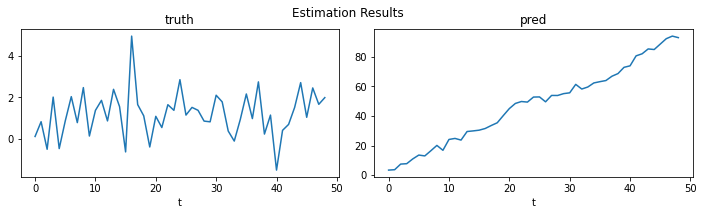

In [81]:
resids = residual(params, pos, neg, self_gr, JH, rank)
model = self_gr - resids

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 3))
fig.suptitle('Estimation Results')
axes[0].plot(self_gr)
axes[0].set_title('truth')
axes[0].set_xlabel('t')
axes[1].plot(model)
axes[1].set_title('pred')
axes[1].set_xlabel('t')
fig.tight_layout()

In [0]:
def plot_two_series(serie1, serie2, figureTitle=None, title1=None, title2=None):
  fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 3))
  fig.suptitle(figureTitle)
  axes[0].plot(serie1)
  axes[0].set_title(title1)
  axes[0].set_xlabel('t')
  axes[1].plot(serie2)
  axes[1].set_title(title2)
  axes[1].set_xlabel('t')
  fig.tight_layout()